In [1]:
import numpy as np

import jax
import jax.numpy as jnp

import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from flax import linen as nn

# M4

With its second data release the Gaia collaboration published [a paper](https://www.aanda.org/articles/aa/abs/2018/08/aa32698-18/aa32698-18.html) where they looked at the kinematics of many globular clusters.  The data release associated with the paper can be found [here](http://cdsarc.u-strasbg.fr/viz-bin/qcat?J/A+A/616/A12), and includes tables of members identified for each cluster they studied.  Let's focus on M4 (a.k.a. NGC 6121), the file for which can be found [here](http://cdsarc.u-strasbg.fr/ftp/J/A+A/616/A12/files/NGC6121-1.dat).

```bash
!wget http://cdsarc.u-strasbg.fr/ftp/J/A+A/616/A12/files/NGC6121-1.dat -O ../data/NGC6121-1.dat
```

In [2]:
!head ../data/NGC6121-1.dat

6045504229661220736 245.99162               -26.34434           18.438   
6045504981264184192 246.03035               -26.28057           18.769   
6045508902585952640 245.88761               -26.24297           19.072   
6045507180287440000 245.85343               -26.28453           18.495   
6045503473747038464 245.87124               -26.34628           17.163   
6045504229661219200 245.99971               -26.34076           17.441   
6045507459476748288 245.78997               -26.31094           18.499   
6045504160935345408 246.00232               -26.35289           18.593   
6045508077952053760 245.82044               -26.26234           17.033   
6045504229661219712 245.99428               -26.34374           17.094   


This looks like a fixed-width ASCII file, and if we look at the `README` for the data release we see that the columns are `source_id` (which matches to the IDs in the full Gaia catalog), right-ascension, declination, and G-band magnitude magnitude.  Let's read it in.

In [3]:
m4_df = pd.read_fwf('../data/NGC6121-1.dat', names=['source_id', 'ra', 'dec', 'phot_g_mean_mag'])
m4_df

,source_id,ra,dec,phot_g_mean_mag
0,6045504229661220736,245.99162,-26.34434,18.438
1,6045504981264184192,246.03035,-26.28057,18.769
2,6045508902585952640,245.88761,-26.24297,19.072
3,6045507180287440000,245.85343,-26.28453,18.495
4,6045503473747038464,245.87124,-26.34628,17.163
...,...,...,...,...
19503,6045337962873610240,245.13976,-27.09970,19.705
19504,6045298891556291712,245.48339,-27.19208,19.493
19505,6045305866578950784,245.69445,-27.06942,18.290
19506,6045303774938119808,245.80824,-27.07275,19.267


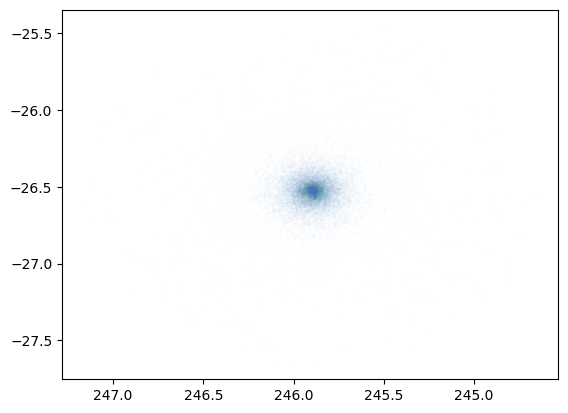

In [4]:
plt.scatter(m4_df.ra, m4_df.dec, s=0.0001)
plt.gca().invert_xaxis()

That looks pretty globular clustery to me.  Let's now pull objects from the Gaia catalog in a box around this location, specifically a 3 degree x 3 degree box centered at `RA=246, dec=-26.5`.  We'll grab object IDs, sky locations, parallaxes, errors, proper motions, etc.

The data corresponding to the query below can be found [here](https://scicomp.gw.observer/view/data/m4_gaia_source.csv).

```sql
SELECT TOP 1000000 gaia_source.designation,gaia_source.source_id,gaia_source.ra,gaia_source.dec,gaia_source.parallax,gaia_source.parallax_error,gaia_source.parallax_over_error,gaia_source.pm,gaia_source.pmra,gaia_source.pmra_error,gaia_source.pmdec,gaia_source.pmdec_error,gaia_source.astrometric_n_good_obs_al,gaia_source.astrometric_chi2_al,gaia_source.visibility_periods_used,gaia_source.phot_g_mean_flux_over_error,gaia_source.phot_g_mean_mag,gaia_source.phot_bp_mean_flux_over_error,gaia_source.phot_bp_mean_mag,gaia_source.phot_rp_mean_flux_over_error,gaia_source.phot_rp_mean_mag,gaia_source.phot_bp_rp_excess_factor,gaia_source.bp_rp,gaia_source.dr2_radial_velocity,gaia_source.dr2_radial_velocity_error
FROM gaiaedr3.gaia_source 
WHERE 
CONTAINS(
	POINT('ICRS',gaiaedr3.gaia_source.ra,gaiaedr3.gaia_source.dec),
	BOX('ICRS',246,-26.5,3,3)
)=1
```

In [5]:
df = pd.read_csv('../data/m4_gaia_source.csv')

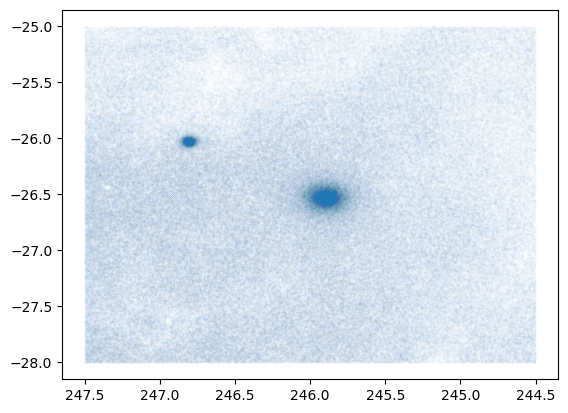

In [6]:
plt.scatter(df.ra, df.dec, s=0.0001)
plt.gca().invert_xaxis()

It looks like we were successful in finding M4, and another cluster may have come along for the ride.

# Dense neural network classifiers

Let's try to build a classifier that, given a star's properties available in the full Gaia catalog, is able to predict whether that star is a member of the globular cluster (we're focusing on M4 specifically at the moment, but generalizing what can be learned here to other clusters would make it a powerful tool!).

First we'll need to perform the cross-matching between the two data sets.  Since we'll want to train on values from the full Gaia catalog, it will be useful to construct a selection array that selects for the cluster members identified in the M4 mini-catalog.  We'll use `pandas` `.isin()` methods to do this.

In [7]:
m4_sel = df['source_id'].isin(m4_df.source_id)
print(np.count_nonzero(m4_sel))

19084


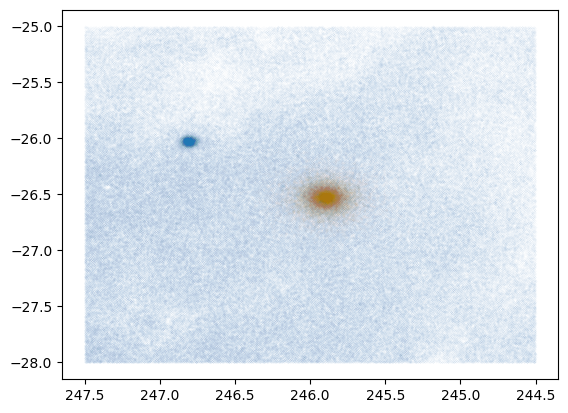

In [9]:
plt.scatter(df.ra[~m4_sel], df.dec[~m4_sel], s=0.0001)
plt.scatter(df.ra[m4_sel], df.dec[m4_sel], s=0.0001)
plt.gca().invert_xaxis()

Sweet.  Let's start off simple and build a classifier based on sky position only.

In [10]:
df.columns

Index(['designation', 'source_id', 'ra', 'dec', 'parallax', 'parallax_error',
       'parallax_over_error', 'pm', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'astrometric_n_good_obs_al', 'astrometric_chi2_al',
       'visibility_periods_used', 'phot_g_mean_flux_over_error',
       'phot_g_mean_mag', 'phot_bp_mean_flux_over_error', 'phot_bp_mean_mag',
       'phot_rp_mean_flux_over_error', 'phot_rp_mean_mag',
       'phot_bp_rp_excess_factor', 'bp_rp', 'radial_velocity',
       'radial_velocity_error'],
      dtype='object')

In [11]:
params = ['ra', 'dec']
X = np.array(df[params])
X.shape

(494996, 2)

It's always good to check for missing values.

In [12]:
np.count_nonzero(np.any(np.isnan(X), axis=1))

0

It doesn't look like we have any yet, but if we try including other data columns we'll find lots.  The information available for each object in the catalog depends on how many times the object was observed (indicated by `visibility_periods_used`).  For example, an object observed only once would have a measured location (RA and dec), but no proper motion, etc.  If there _were_ missing values, we would remove them like so.

In [13]:
nans = np.any(np.isnan(X), axis=1)
X = X[~nans]

n_classes = 2
y = m4_sel.astype(int)[~nans]

Let's standardize our data by transforming it to have a $\vec{0}$ mean and unit 1-D variances.

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
transformer = StandardScaler()

X = transformer.fit_transform(X)

Now we'll randomly select $10\%$ of the data to reserve for testing and use the rest for training.  We also need to prepare our output vectors.  In this case we have a simple binary classification task, but to simplify the transition from our previous use of a dense NN to classify handwritten digits, let's treat the problem as if it's a multi-class problem, i.e., use two output nodes and integer labels.

In [16]:
m = X.shape[0]
test_frac = 0.1
test_sel = np.random.choice([True, False], size=m, p=[test_frac, 1-test_frac])
X_tst = X[test_sel]
X_train = X[~test_sel]

y_tst = y[test_sel]
y_train = y[~test_sel]

...

In [17]:
X_train = jnp.array(X_train)
X_tst = jnp.array(X_tst)
y_train = jnp.array(y_train)
y_tst = jnp.array(y_tst)

Where for MNIST we used builtin methods from `tensorflow_datasets` to batch our data, we'll need to do our own batching here.  We'll make a new dimension to the data that will cover batches, and we'll drop the leftover bits that don't divide evenly.

In [18]:
batch_size = 64
n_batches = X_train.shape[0] // batch_size

X_train = X_train[:n_batches * batch_size].reshape((n_batches, batch_size, *X_train.shape[1:]))
y_train = y_train[:n_batches * batch_size].reshape((n_batches, batch_size, *y_train.shape[1:]))
X_train.shape, y_train.shape

((6961, 64, 2), (6961, 64))

We now have everything prepared for model training.  Let's start off with the same basic architecture we used in the previous example, with fewer nodes in our hidden layers (we only have 2 input features, compared to all the pixels with the MNIST data).

In [19]:
n_classes = 2

class DenseClassifier(nn.Module):
    """A simple dense classifier."""

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(n_classes)(x)
        return x

Let's take a look at the summary of the model.

In [20]:
dummy_input = jnp.ones((1, 2))
dnn = DenseClassifier()
print(dnn.tabulate(jax.random.PRNGKey(0), dummy_input))


                            DenseClassifier Summary                             
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module          ┃ inputs        ┃ outputs       ┃ params           ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│         │ DenseClassifier │ float32[1,2]  │ float32[1,2]  │                  │
├─────────┼─────────────────┼───────────────┼───────────────┼──────────────────┤
│ Dense_0 │ Dense           │ float32[1,2]  │ float32[1,10] │ bias:            │
│         │                 │               │               │ float32[10]      │
│         │                 │               │               │ kernel:          │
│         │                 │               │               │ float32[2,10]    │
│         │                 │               │               │                  │
│         │                 │               │               │ 30 (120 B)       │
├─────────┼────────────────

In [21]:
X_train.shape, y_train.shape

((6961, 64, 2), (6961, 64))

It looks like our model has $162$ trainable parameters.  Let's train them.

We're going to mostly cut and paste all the metric and training bits from our last Dense-NN modeling effort.

In [22]:
from clu import metrics
from flax.training import train_state
from flax import struct
import optax

In [23]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
   metrics: Metrics

In [24]:
def create_train_state(model, rng, learning_rate):
    params = model.init(rng, dummy_input)['params']
    tx = optax.adam(learning_rate)
    return TrainState.create(
        apply_fn=model.apply, params=params, tx=tx,
        metrics=Metrics.empty())

In [25]:
@jax.jit
def train_step(state, batch, label):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

In [26]:
@jax.jit
def compute_metrics(*, state, batch, label):
    logits = state.apply_fn({'params': state.params}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=label, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [27]:
init_rng = jax.random.PRNGKey(0)

learning_rate = 0.01

state = create_train_state(dnn, init_rng, learning_rate)
del init_rng  # Must not be used anymore.

In [28]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [29]:
n_epochs = 50

In [30]:
step = 0

for _ in range(n_epochs):
  for batch, label in zip(X_train, y_train):

    # Run optimization steps over training batches and compute batch metrics
    state = train_step(state, batch, label) # get updated train state (which contains the updated parameters)
    state = compute_metrics(state=state, batch=batch, label=label) # aggregate batch metrics

    if (step+1) % n_batches == 0: # one training epoch has passed
      for metric,value in state.metrics.compute().items(): # compute metrics
        metrics_history[f'train_{metric}'].append(value) # record metrics
      state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

      # Compute metrics on the test set after each training epoch
      test_state = state
      test_state = compute_metrics(state=test_state, batch=X_tst, label=y_tst)

      for metric,value in test_state.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)

      print(f"train epoch: {(step+1) // n_batches}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
      print(f"test epoch: {(step+1) // n_batches}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")
    step += 1

train epoch: 1, loss: 0.07667232304811478, accuracy: 96.145263671875
test epoch: 1, loss: 0.17520391941070557, accuracy: 96.14949035644531
train epoch: 2, loss: 0.07627656310796738, accuracy: 96.17085266113281
test epoch: 2, loss: 0.12213152647018433, accuracy: 96.14949035644531
train epoch: 3, loss: 0.07635080069303513, accuracy: 96.16098022460938
test epoch: 3, loss: 0.17590850591659546, accuracy: 96.14949035644531
train epoch: 4, loss: 0.07624281197786331, accuracy: 96.19082641601562
test epoch: 4, loss: 0.10561568289995193, accuracy: 96.14949035644531
train epoch: 5, loss: 0.07626849412918091, accuracy: 96.19419860839844
test epoch: 5, loss: 0.13711287081241608, accuracy: 96.14949035644531
train epoch: 6, loss: 0.07635106891393661, accuracy: 96.19509887695312
test epoch: 6, loss: 0.1189332976937294, accuracy: 96.14949035644531
train epoch: 7, loss: 0.07630562782287598, accuracy: 96.18207550048828
test epoch: 7, loss: 0.1091783419251442, accuracy: 96.14949035644531
train epoch: 8, l

Let's look at the accuracy over the training epochs.

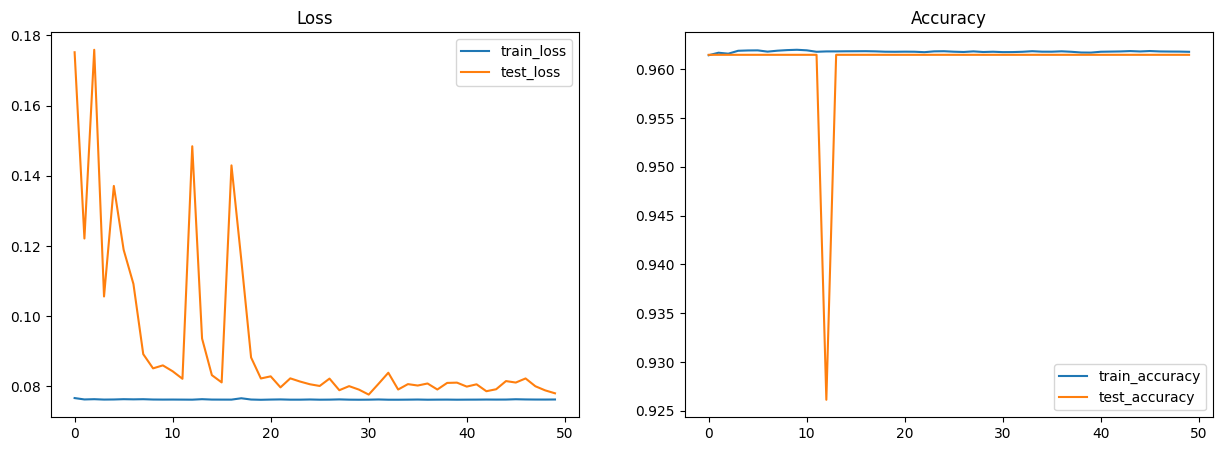

<Figure size 640x480 with 0 Axes>

In [31]:
# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

Not a ton of improvement on the testing loss — and remember that $\sim 96\%$ of the objects in our set are _not_ part of the cluster — getting accuracies around that is not very difficult. Let's get a visual of how the classifier is doing.

Remember that the output of our network for a single object is a two-element vector, and a larger value in the first column indicates a non-cluster-member prediction, and a larger second value indicates a cluster-member prediction. 

In [32]:
@jax.jit
def pred_step(state, batch):
  logits = state.apply_fn({'params': state.params}, batch)
  return logits.argmax(axis=1)

pred = pred_step(state, X_tst)
pred

Array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

(array([    0.,     0.,     0.,     0.,     0., 49474.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

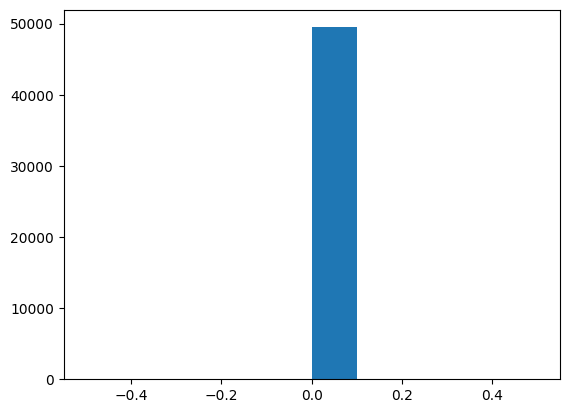

In [33]:
plt.hist(pred)

Instead of turning the output into discrete prediction, let's look at the difference (remember these are "log"its) of the values from the output nodes to see if it's picking up hints of something useful.

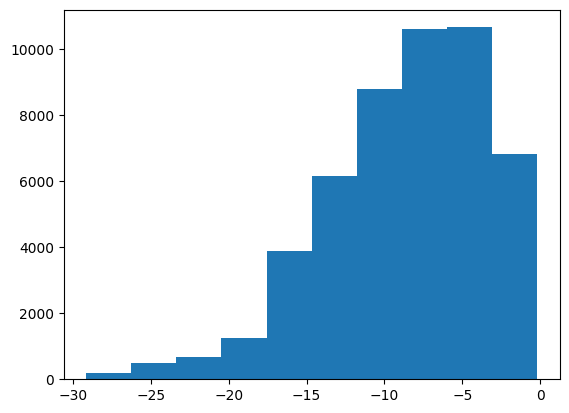

In [34]:
outputs = state.apply_fn({'params': state.params}, X_tst)
plt.hist(jnp.diff(outputs, axis=1).flatten());

It looks like none of the objects are confidently associated with the cluster (> 0).  Let's see if the ones that it's least certain about are at least in the right part of the sky.

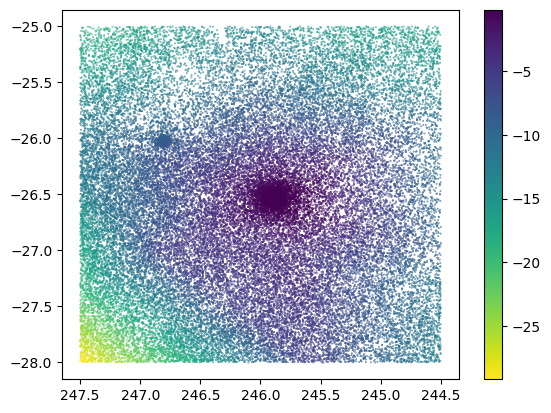

In [35]:
plt.scatter(df.ra[~nans][test_sel], df.dec[~nans][test_sel], c=jnp.diff(outputs, axis=1), s=.1, cmap='viridis_r')
plt.colorbar()

plt.gca().invert_xaxis()

Interesting.  So even though it's not able to make any confident predictions for stars being in the cluster, it's at least able to tell the part of the sky that's most likely to contain them....